<a href="https://colab.research.google.com/github/Dashcloud-ML/ml_projects/blob/main/Gold_Price_Pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Gold Price Prediction using Machine Learning**

---



#**Importing Libraries**
We will import all the libraries that we will be using throughout this article in one place so that do not have to import every time we use it this will save both our time and effort.

Pandas – A Python library built on top of NumPy for effective matrix multiplication and dataframe manipulation, it is also used for data cleaning, data merging, data reshaping, and data aggregation
Numpy – A Python library that is used for numerical mathematical computation and handling multidimensional ndarray, it also has a very large collection of mathematical functions to operate on this array
Matplotlib – It is used for plotting 2D and 3D visualization plots, it also supports a variety of output formats including graphs
Seaborn – seaborn library is made on top of Matplotlib it is used for plotting beautiful plots.

In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
sns.set_style("darkgrid", {"grid.color": ".6",
						"grid.linestyle": ":"})

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV


In [2]:
# read dataset using pndas function
# use parse_dates argument to change datetime dtype
dataset = pd.read_csv("gold_price_data.csv",
					parse_dates=["Date"])


In [3]:
# information about the dataset
dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2290 entries, 0 to 2289
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     2290 non-null   datetime64[ns]
 1   SPX      2290 non-null   float64       
 2   GLD      2290 non-null   float64       
 3   USO      2290 non-null   float64       
 4   SLV      2290 non-null   float64       
 5   EUR/USD  2290 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 107.5 KB


#**Data preprocessing**  – Missing Values/Null Values
Missing values have a very drastic effect on our model training. some of the models like LinearRegression do not fit the dataset which has missing values in it. However, there are some models which work well even with a missing dataset like RandomForest. But it is always a good practice to handle missing values first when working with the dataset. Also, one thing to note is that when we load the data using pandas it automatically detects null values and replaces them with NAN.

In [4]:
# Missing Values/Null Values Count
dataset.isna().sum().sort_values(ascending=False)


,0
Date,0
SPX,0
GLD,0
USO,0
SLV,0
EUR/USD,0


#**Correlation Between Columns**

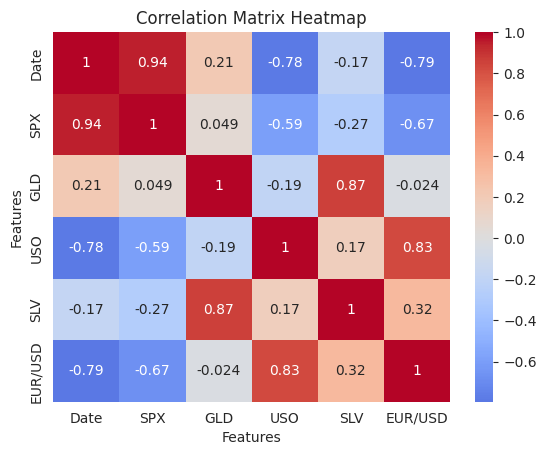

In [5]:
# Calculate correlation matrix
correlation = dataset.corr()

# Create heatmap
sns.heatmap(correlation, cmap='coolwarm',
			center=0, annot=True)

# Set title and axis labels
plt.title('Correlation Matrix Heatmap')
plt.xlabel('Features')
plt.ylabel('Features')

# Show plot
plt.show()


In [6]:
# drop SlV column
dataset.drop("SLV", axis=1,
			inplace=True)


#**Data Wrangling**
Data wrangling is one of the main steps We use in a data science project to gain insight and knowledge from the data. We see data through every aspect and try to fetch most of the information from the dataframe.

We will first set the Date column as the index of the dataframe using the date as an index will add an advantage in plotting the data  

In [7]:
# reset the index to date column
dataset.set_index("Date", inplace=True)


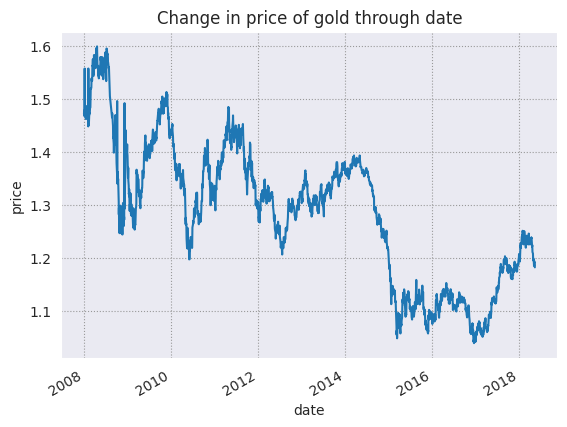

In [8]:
# plot price of gold for each increasing day
dataset["EUR/USD"].plot()
plt.title("Change in price of gold through date")
plt.xlabel("date")
plt.ylabel("price")
plt.show()


#**Trend in Gold Prices Using Moving Averages**

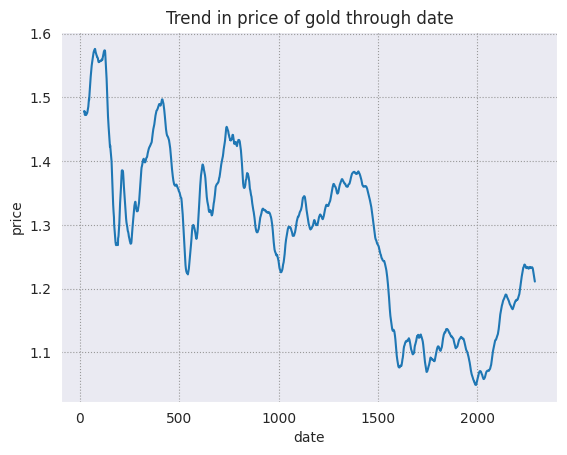

In [9]:
# apply rolling mean with window size of 3
dataset["price_trend"] = dataset["EUR/USD"]\
	.rolling(window=20).mean()

# reset the index to date column
dataset.reset_index("Date", inplace=True)

# since we have used rolling method
# for 20 rows first 2 rows will be NAN
dataset["price_trend"].loc[20:].plot()

# set title of the chart
plt.title("Trend in price of gold through date")

# set x_label of the plot
plt.xlabel("date")
plt.ylabel("price")
plt.show()


#**Distribution  of Columns**



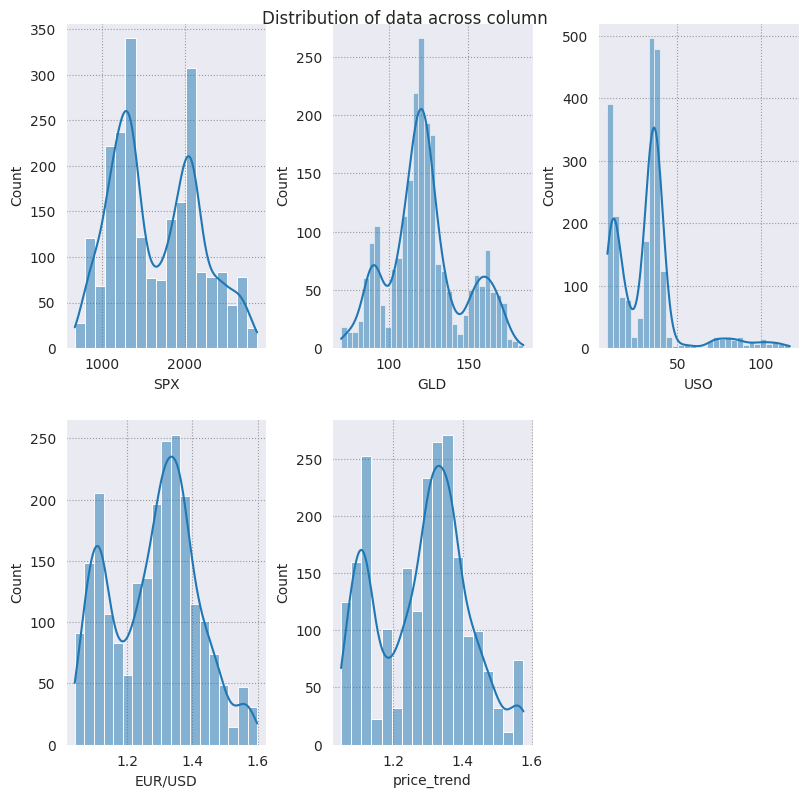

In [10]:
fig = plt.figure(figsize=(8, 8))

# suptitle of the graph
fig.suptitle('Distribution of data across column')
temp = dataset.drop("Date", axis=1).columns.tolist()
for i, item in enumerate(temp):
	plt.subplot(2, 3, i+1)
	sns.histplot(data=dataset, x=item, kde=True)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)
plt.show()


In [14]:
# skewness along the index axis
# Drop datetime columns and calculate skewness
numeric_data = dataset.select_dtypes(exclude=['datetime', 'timedelta'])
print(numeric_data.skew(axis=0, skipna=True))



SPX            0.300362
GLD            0.334138
USO            0.599864
EUR/USD       -0.005292
price_trend   -0.029588
dtype: float64


In [12]:
# apply saquare root transformation
# on the skewed dataset
dataset["USO"] = dataset["USO"]\
	.apply(lambda x: np.sqrt(x))


#**Handling Outliers**
#**Plotting Boxplot to Visualize the Outliers**

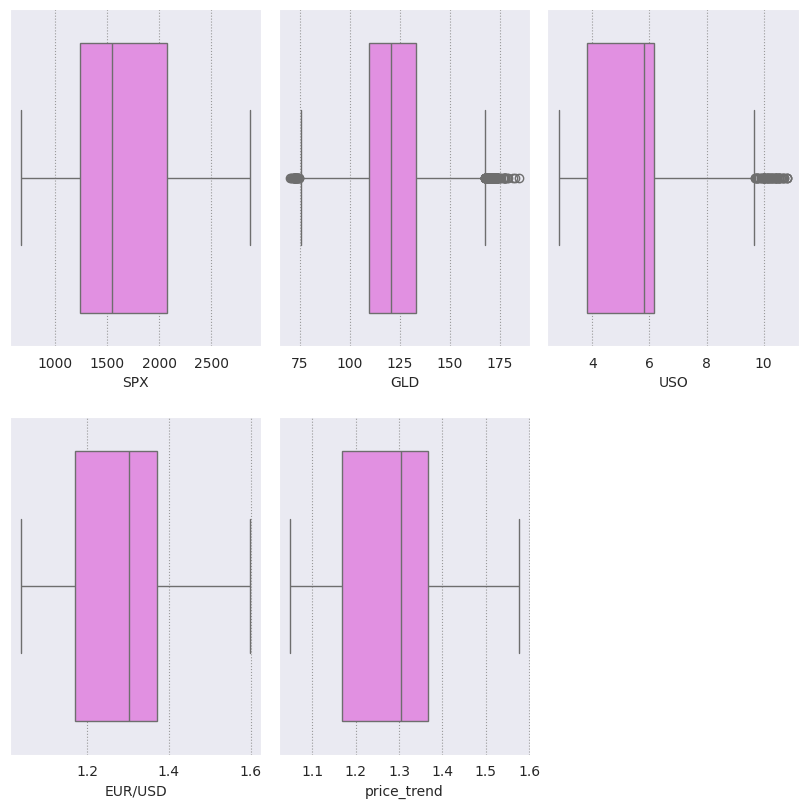

In [15]:
fig = plt.figure(figsize=(8, 8))
temp = dataset.drop("Date", axis=1).columns.tolist()
for i, item in enumerate(temp):
	plt.subplot(2, 3, i+1)
	sns.boxplot(data=dataset, x=item, color='violet')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)
plt.show()


In [16]:
def outlier_removal(column):
	# Capping the outlier rows with Percentiles
	upper_limit = column.quantile(.95)
	# set upper limit to 95percentile
	lower_limit = column.quantile(.05)
	# set lower limit to 5 percentile
	column.loc[(column > upper_limit)] = upper_limit
	column.loc[(column < lower_limit)] = lower_limit
	return column


In [17]:
# Normalize outliers in columns except Date

dataset[['SPX', 'GLD', 'USO', 'EUR/USD']] = \
	dataset[['SPX', 'GLD', 'USO', 'EUR/USD']].apply(outlier_removal)


#**Modeling the Data**

In [18]:
# select the features and target variable
X = dataset.drop(['Date', 'EUR/USD'], axis=1)

y = dataset['EUR/USD']
# dividing dataset in to train test
x_train, x_test,\
	y_train, y_test = train_test_split(X, y,
									test_size=0.2)


#**Scaling the data**

In [19]:
# Create an instance of the StandardScaler
scaler = StandardScaler()

# Fit the StandardScaler on the training dataset
scaler.fit(x_train)

# Transform the training dataset
# using the StandardScaler
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)


#**Lasso Regression**
In this model, we have used linear regression with L1 Regularization, also with help of the make_pipeline object, we will use lasso regression with 2 degrees. We will also use the GridSearch object in every model to get the best-performing hyperparameter and lower the variance.

In [27]:
# Assume x_train_scaled and y_train are already defined

# Check for missing values
print("Missing values in x_train_scaled: ", np.isnan(x_train_scaled).sum())
print("Missing values in y_train: ", np.isnan(y_train).sum())

# Handle missing values by imputing with the mean
imputer = SimpleImputer(strategy='mean')
x_train_imputed = imputer.fit_transform(x_train_scaled)

# Create a PolynomialFeatures object of degree 2
poly = PolynomialFeatures(degree=2)

# Create a Lasso object
lasso = Lasso()

# Define a dictionary of parameter values to search over
param_grid = {'lasso__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1, 5]}

# Create a pipeline that first applies polynomial features and then applies Lasso regression
pipeline = make_pipeline(StandardScaler(), poly, lasso)

# Create a GridSearchCV object with the pipeline and parameter grid
lasso_grid_search = GridSearchCV(pipeline, param_grid, scoring='r2', cv=3, error_score='raise')

# Fit the GridSearchCV object to the training data
lasso_grid_search.fit(x_train_imputed, y_train)

# Predict the target variable using the fitted model and the test data
y_pred = lasso_grid_search.predict(x_train_imputed)

# Compute the R-squared of the fitted model on the training data
r2 = r2_score(y_train, y_pred)

# Print the R-squared
print("R-squared: ", r2)

# Print the best parameter values and score
print('Best parameter values: ', lasso_grid_search.best_params_)
print('Best score: ', lasso_grid_search.best_score_)

Missing values in x_train_scaled:  17
Missing values in y_train:  0
R-squared:  0.9660469072665873
Best parameter values:  {'lasso__alpha': 0.0001}
Best score:  0.9646229206916711


#**RandomForestRegressor for Regression**

In [32]:


# Instantiate the RandomForestRegressor
rf = RandomForestRegressor()

# Define the parameter grid
param_grid = {'n_estimators': [50, 80, 100], 'max_depth': [3, 5, 7]}

# Define GridSearchCV with the RandomForestRegressor
rf_grid_search = GridSearchCV(rf, param_grid, scoring='r2', cv=2, error_score='raise')

# Fit the GridSearchCV object to the training data
rf_grid_search.fit(x_train_imputed, y_train)

# Print the best parameter values and score
print('Best parameter values: ', rf_grid_search.best_params_)
print('Best score: ', rf_grid_search.best_score_)


Best parameter values:  {'max_depth': 7, 'n_estimators': 100}
Best score:  0.9747765378014828


In [38]:
# Compute the R-squared of the
# fitted model on the test data
r2 = r2_score(y_test,
			rf_grid_search.predict(x_test_scaled))

# Print the R-squared
print("R-squared:", r2)


ValueError: Input X contains NaN.
RandomForestRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

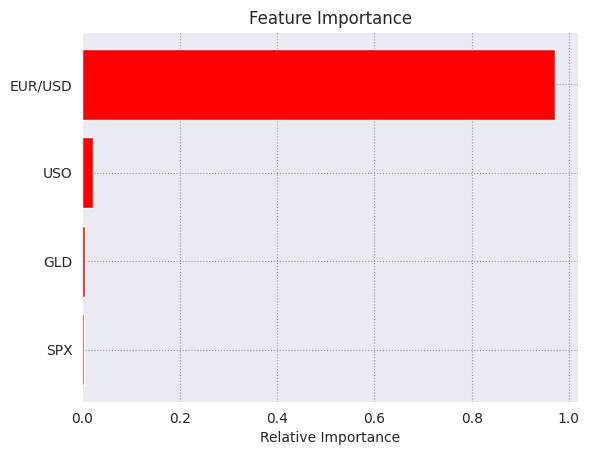

In [39]:
features = dataset.drop("Date", axis=1).columns

# store the importance of the feature
importances = rf_grid_search.best_estimator_.\
	feature_importances_


indices = np.argsort(importances)

# title of the graph
plt.title('Feature Importance')

plt.barh(range(len(indices)),
		importances[indices],
		color='red',
		align='center')

# plot bar chart
plt.yticks(range(len(indices)),
		[features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


#**XGBoost Model for Regression**
In Boosting Technique the data is fitted in several sequential Weak learning algorithm models which are only slightly better than random guessing. In each next sequential model more Weights are given to the points are which are misclassified/regressed by previous models

In our models, we will use the XGBOOST model for fitting our training dataset.

In [40]:
# Create an instance of the XGBRegressor model
model_xgb = XGBRegressor()

# Fit the model to the training data
model_xgb.fit(x_train_scaled, y_train)

# Print the R-squared score on the training data
print("Xgboost Accuracy =", r2_score(
	y_train, model_xgb.predict(x_train_scaled)))


Xgboost Accuracy = 0.9993837058404625


In [41]:
# Print the R-squared score on the test data
print("Xgboost Accuracy on test data =",
	r2_score(y_test,
			model_xgb.predict(x_test_scaled)))


Xgboost Accuracy on test data = 0.9886516764058653


In [42]:
pip install eli5


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107721 sha256=60c0fd9ddf6ab0a3cbbd007d15d30c16c3d137d35328700d4a5c1eee83b55059
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e07007085c0004
Successfully built eli5


In [57]:
import eli5 as eli
feature_names = x_train.columns.tolist()

# Initialize PermutationImportance with your model
perm = PermutationImportance(model_xgb, random_state=42)

# Fit the permutation importance
perm.fit(x_train, y_train)

# Explain the weights of the features using ELI5
eli5.explain_weights(perm, feature_names=feature_names)


ImportError: cannot import name 'if_delegate_has_method' from 'sklearn.utils.metaestimators' (/usr/local/lib/python3.10/dist-packages/sklearn/utils/metaestimators.py)

In [53]:
pip install --upgrade scikit-learn eli5


In [54]:
pip install shap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 10.4 MB/s eta 0:00:00


In [49]:
pip install --upgrade scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 54.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2


In [50]:
pip install --upgrade eli5
